In [106]:
import analysis as an
from analysis import Action, Bill

from dateutil.parser import parse
from datetime import datetime

from itertools import chain
from collections import namedtuple
import json
import re

import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import networkx as nx

In [352]:


actions_df = pd.read_csv('../data/all-history-actions.csv')

head_df = pd.DataFrame(actions_df.sample(40))

head_df['referenced_bills'] = head_df['action'].apply(an.findBillNum.findall)
head_df['a_id'] = [f"{x}_{index}" for index, x in enumerate(head_df['id'])] 
head_df_grouped = head_df.groupby('id')
head_df['date_day'] = actions_df['date'].apply(lambda x : an.date_day(x))
head_df['date_time'] = head_df['date'].apply(lambda x : an.date_time(x))
# head_df['number_of_connections'] = head_df['referenced_bills'].apply(lambda x : len(x))

NodeView(('H', 'H2734_0', '2', '7', '3', '4', '_', '0', 'H4361_1', 'H3688_2', '6', '1', 'H4372_3', '8', 'S22_4', 'S', 'S2278_5', 'H2068_6', '5', 'H2411_7', 'H1725_8', 'H4198_9', 'H3427_10', '9', 'H3345_11', 'S610_12', 'H629_13', 'S2705_14', 'H3745_15', 'H4755_16', 'S1823_17', 'H4013_18', 'H2368_19', 'H3459_20', 'H1459_21', 'H4208_22', 'H3832_23', 'H3075_24', 'S3045_25', 'H4645_26', 'S54_27', 'H2213_28', 'H4688_29', 'H4877_30', 'H4489_31', 'H753_32', 'H2084_33', 'H4977_34', 'H1820_35', 'H1224_36', 'H2443_37', 'H201_38', 'S2970_39'))

{'H': ['H', 0],
 'H2734_0': ['H2734_0', 1],
 '2': ['2', 2],
 '7': ['7', 3],
 '3': ['3', 4],
 '4': ['4', 5],
 '_': ['_', 6],
 '0': ['0', 7],
 'H4361_1': ['H4361_1', 8],
 'H3688_2': ['H3688_2', 9],
 '6': ['6', 10],
 '1': ['1', 11],
 'H4372_3': ['H4372_3', 12],
 '8': ['8', 13],
 'S22_4': ['S22_4', 14],
 'S': ['S', 15],
 'S2278_5': ['S2278_5', 16],
 'H2068_6': ['H2068_6', 17],
 '5': ['5', 18],
 'H2411_7': ['H2411_7', 19],
 'H1725_8': ['H1725_8', 20],
 'H4198_9': ['H4198_9', 21],
 'H3427_10': ['H3427_10', 22],
 '9': ['9', 23],
 'H3345_11': ['H3345_11', 24],
 'S610_12': ['S610_12', 25],
 'H629_13': ['H629_13', 26],
 'S2705_14': ['S2705_14', 27],
 'H3745_15': ['H3745_15', 28],
 'H4755_16': ['H4755_16', 29],
 'S1823_17': ['S1823_17', 30],
 'H4013_18': ['H4013_18', 31],
 'H2368_19': ['H2368_19', 32],
 'H3459_20': ['H3459_20', 33],
 'H1459_21': ['H1459_21', 34],
 'H4208_22': ['H4208_22', 35],
 'H3832_23': ['H3832_23', 36],
 'H3075_24': ['H3075_24', 37],
 'S3045_25': ['S3045_25', 38],
 'H4645_26'

UFuncTypeError: ufunc 'minimum' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> None

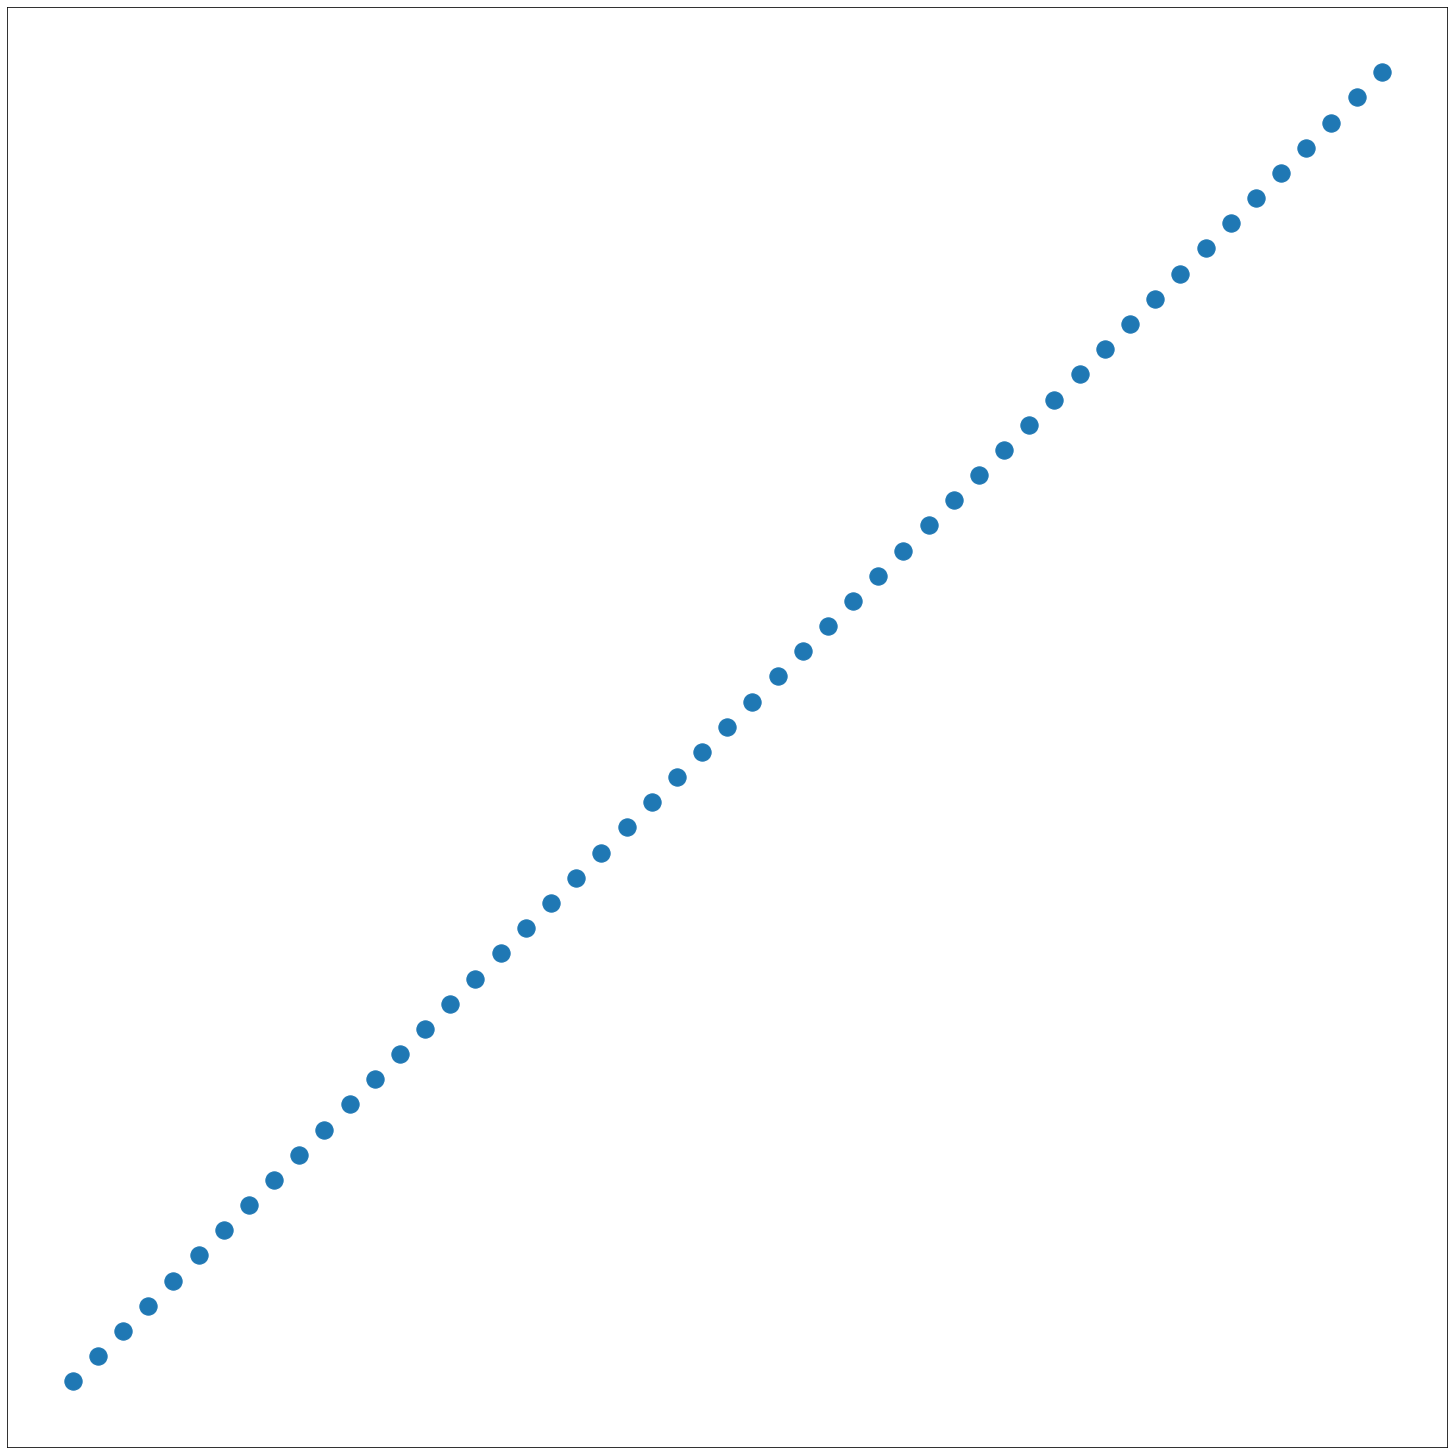

In [357]:

from cProfile import label


Edge = namedtuple('Edge', ['source', 'target'])
ActionNode = namedtuple('ActionNode', ['id', "action", 'branch', 'date', 'referenced_bills', 'a_id', 'date_day', 'date_time', 'targets'])

def getEdges(action_node: ActionNode): 
  edges = []
  a_id = action_node.a_id
  for t in action_node.targets:
    edges.append(Edge(a_id, t))
  return edges

nodes: list[ActionNode] = []
edges: list[Edge] = []


prev_r = None

for r in head_df.itertuples(index=False):
  id, action, branch, date, referenced_bills, a_id, date_day, date_time,  *other = r
  
  targets = prev_r.a_id if prev_r != None else r.a_id
  
  node = ActionNode(id, action, branch, date, referenced_bills, a_id, date_day, date_time, targets)
  nodes.append(node)
  for t in node.targets:
    e = Edge(t, a_id)
    edges.append(e)
  prev_r = r
    
  
  # id, action, branch, date, referenced_bills,  a_id, date_day, date_time = r
  # targets = an.findBillNum.findall(action)
    
  
G = nx.DiGraph()

G.add_edges_from(edges)
G.add_nodes_from([n.a_id for n in nodes])

display(G.nodes)

pl.figure(figsize=[20, 20])

pos = {n: [n, index] for index, n in enumerate(G.nodes)}

display(pos)
nx.draw(G, pos)
nx.draw_networkx_labels(G, pos, font_size=20)
nx.draw_networkx_nodes(G, pos, node_size=1000)

In [ ]:
bills: list[str] = list(set([i.id for i in an.actions]))


connections: dict[str, list[str]] = {}
visited: list[str] = []

for b in ['H3697'] + list(an.collectConnections("H3697")): 
  if b not in connections and b not in visited:
    conns: list[str] = list(an.getReferencedBills(an.getHistory(b)))
    print(b, conns)
    connections.update({b:conns})
  visited.append(b)


In [ ]:

display(connections.items())

bill_edges = []
visited = []

for i in connections:
  if i not in visited: 
    length = len(connections[i])
    if length > 1:
      for b in connections[i]: 
          bill_edges.append((i,b, {'weight': length*10}))
      visited.extend([i] + connections[i])
        

# display(bill_edges, visited)

In [6]:

df_sorted = actions_df.sort_values(by='number_of_connections', ascending=False)

connections = actions_df[(actions_df['number_of_connections'] > 6)& (actions_df['number_of_connections'] < 10)]

In [7]:
np_actions = connections.to_records()

edges = []

for i in np_actions:
  for b in i.referenced_bills: 
    edges.append((i.id,b, {'weight': i.date}))


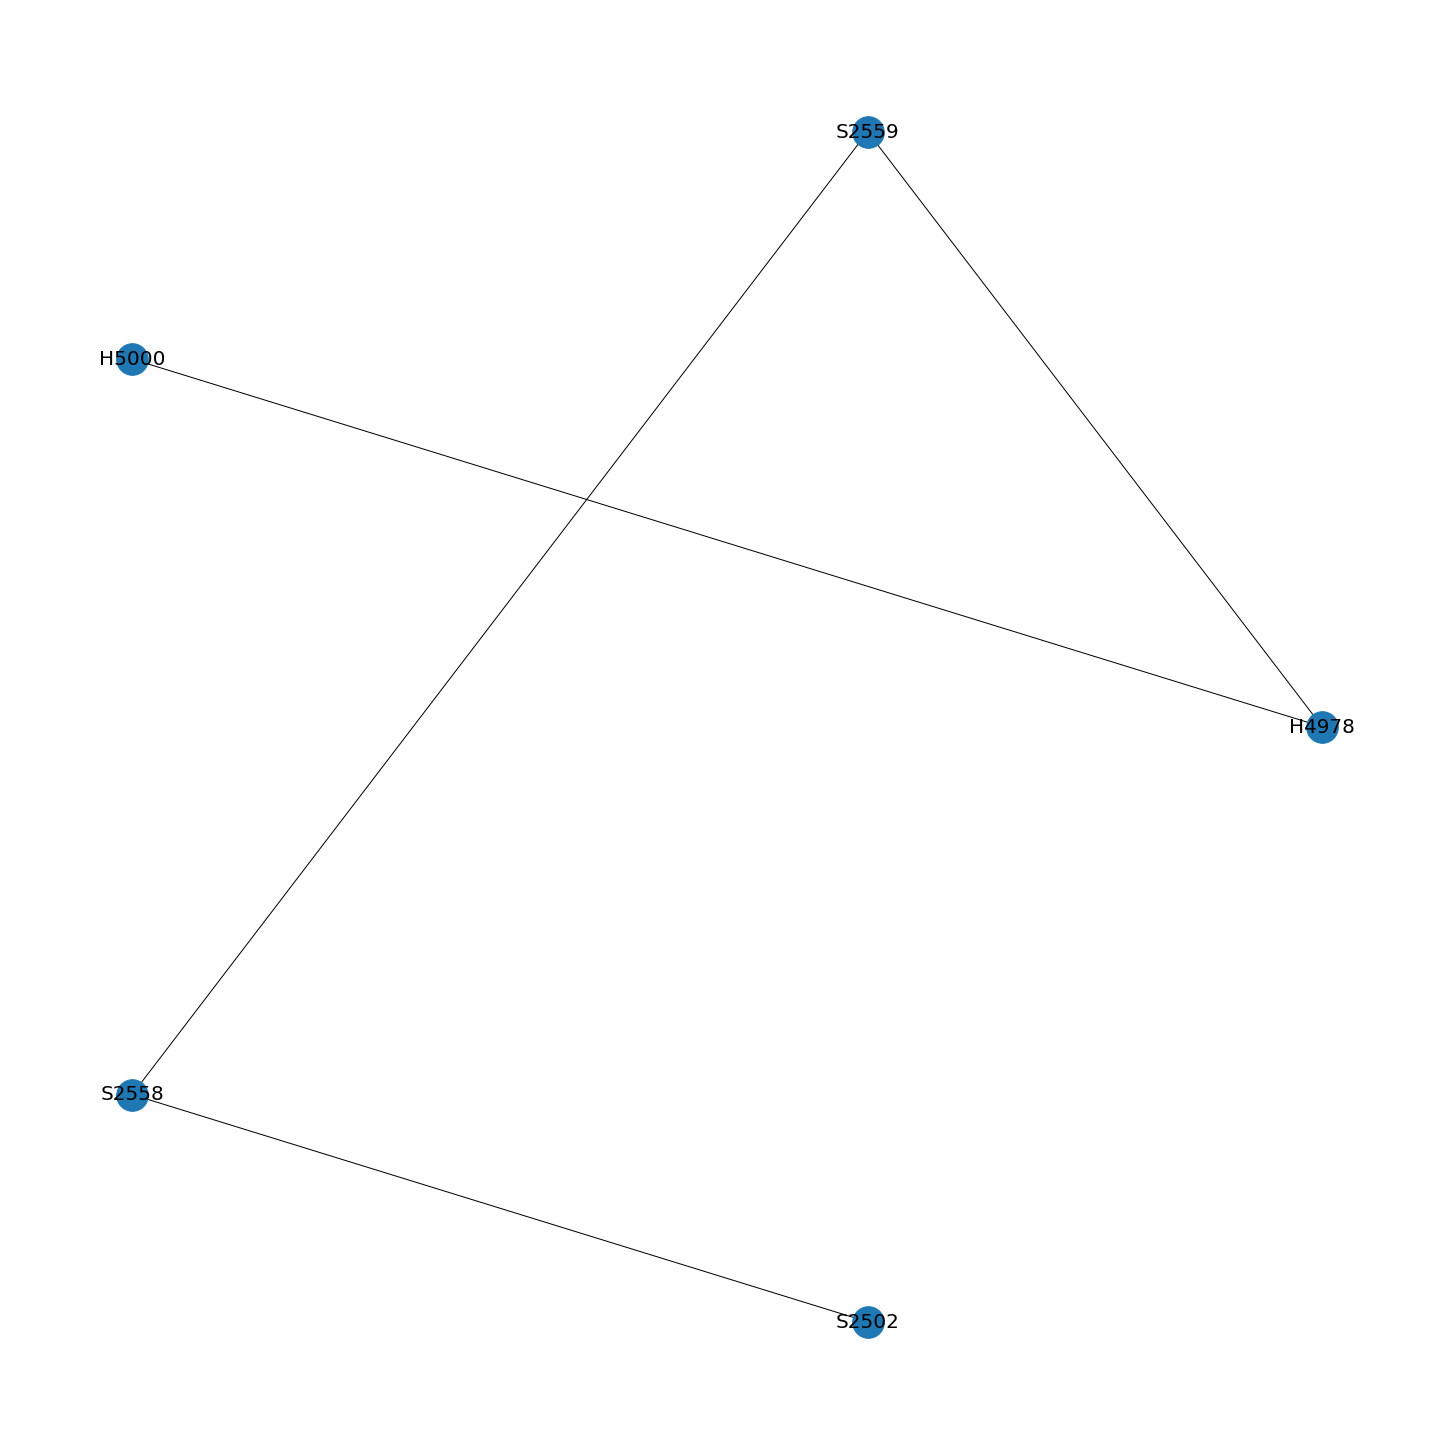

In [8]:

G = nx.DiGraph()

G.add_edges_from(bill_edges)
pos=nx.circular_layout(G)
pl.figure(3,figsize=(20,20)) 


nx.draw(G, pos)
nx.draw_networkx_labels(G, pos, font_size=20)
nx.draw_networkx_nodes(G, pos, node_size=1000)
pl.show()
